In [74]:
import pandas as pd
import numpy as np
import h5py
import scipy.io as sio
import scipy.signal 
import datetime
from skrebate import SURF, MultiSURF, SURFstar
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os 
import pickle
import collections
import sys
sys.path.insert(0,r'C:\Users\hfran\Desktop\FRANCIS\TWH_NURIP_Clinical_Trial\python\EUDB_Python_Framework')
import EUDB
from scipy import stats 

In [2]:
def archive_data(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        
def load_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def resample_data(data, num_samps):
    random_samp_idx = sorted(np.random.randint(data.shape[0], size=num_samps))
    return data[random_samp_idx,:]

def plot_raw_eeg(signals):

    p = None
    num_channels = signals.shape[1]
    
    fig, axes = plt.subplots(num_channels,1, sharex=True)
    fig.set_size_inches(8,40)
    for i in range(num_channels):
        axes[i].plot(signals[:,i])
        axes[i].set_yticks([])
        #axes[i].set_ylabel(c[i])
        
    #plt.tight_layout(w_pad=0)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.show()


In [51]:
data_dir = r'C:\Users\hfran\Desktop\FRANCIS\TWH113'
usb_dir = r'E:\OneDrive - University of Toronto\Thesis\pat_FR_1096'
filenames = []
archive_data_ena = True
sample_data_ena = False

chan_names = None

# Run through directory, and group all the files together
datafiles_ictal = [] #collections.defaultdict(list)
for root, dirs, files in os.walk(data_dir):
    for f in files:
        fname_split = f.split('_')
        is_meta = fname_split[3] == 'metadata.mat'
        if is_meta:
            dataset_name = '_'.join(fname_split[:3])
            print(os.path.join(root,f))
            metadata = sio.loadmat(os.path.join(root,f))
            onset = metadata['idx_sz_start'][0][0]
            end = metadata['idx_sz_end'][0][0]
        
            
            if onset!=0 :
                filename = dataset_name + '_fvs_se.mat'
                matfile = h5py.File(os.path.join(root,filename),'r')
                fvs_data = matfile['fvs_se'][:,onset-10000:end].transpose()
                # fvs_data = np.vstack([fvs_data]*10)
                print(fvs_data.shape)
                
            else:
                filename = dataset_name + '_fvs_se_ss_1000.mat'
                matfile = h5py.File(os.path.join(root,filename),'r')
                fvs_data = matfile['fvs_se_ss_1000'][:,:].transpose()
                
            chan_names = matfile['chanNames']

            matfile.close()

            datafiles_ictal.append({'is_ictal' : onset!=0, 'datapath' : filename, 'data': fvs_data, 
                                       'sz_start' : onset, 'sz_end': end})
            

C:\Users\hfran\Desktop\FRANCIS\TWH113\TWH113_17032019_175430_metadata.mat
C:\Users\hfran\Desktop\FRANCIS\TWH113\TWH113_17032019_182510_metadata.mat
C:\Users\hfran\Desktop\FRANCIS\TWH113\TWH113_17032019_185546_metadata.mat
C:\Users\hfran\Desktop\FRANCIS\TWH113\TWH113_17032019_192628_metadata.mat
C:\Users\hfran\Desktop\FRANCIS\TWH113\TWH113_18032019_013327_metadata.mat
C:\Users\hfran\Desktop\FRANCIS\TWH113\TWH113_18032019_141648_metadata.mat
(15220, 2688)


In [55]:
chan_names = ['LAM1','LAM2','LAM3','LAM4','LAM5','LAM6','LAM7','LAM8','LAHC1','LAHC2','LAHC3','LAHC4','LAHC5','LAHC6','LAHC7','LAHC8','LPHG1','LPHG2','LPHG3','LPHG4','LPHG5','LPHG6','LPHG7','LPHG8','LPHC1','LPHC2','LPHC3','LPHC4','LPHC5','LPHC6','LPHC7','LPHC8','RAM1','RAM2','RAM3','RAM4','RAM5','RAM6','RAM7','RAM8','RAHC1','RAHC2','RAHC3','RAHC4','RAHC5','RAHC6','RAHC7','RAHC8','RPHG1','RPHG2','RPHG3','RPHG4','RPHG5','RPHG6','RPHG7','RPHG8','RPHC1','RPHC2','RPHC3','RPHC4','RPHC5','RPHC6','RPHC7','RPHC8']

In [115]:
# create datasets for sampling 
'''
Datasets for Training and Testing are created as follows: 
for s in seizures:
    X_train = sorted( ictals + subclinicals + intericitals )
    X_test = s 
    surf ( random sampling of X_train)
    svm.train (X_train)
    result = svm_test(X_test)
    performances.append(result)
'''

def generate_labels(data):
    # generate labels for dataset, leaving out specified datarecord 
    
    
    
    all_X = np.vstack([ x['data'] for x in data ])
    all_y = np.concatenate([ np.ones(x['data'].shape[0]) * x['is_ictal'] for x in data ])
    
    # normalize the data with zscore 
    all_X = stats.zscore(all_X)
    
    return all_X, all_y
    

window_size = 150
overlap = 0.75
def windowed_comparison(x,y, c=None):
    if not c:
        surf_train_ena = True
        c = []
    else: surf_train_ena = False
    
    # Create Reference Window 
    ## Get all X for which y = 0
    interictals = x[y==0]
    ictals = x[y==1]
    
    random_samp_idx = sorted(np.random.randint(interictals.shape[0], size=window_size))
    ref_window = interictals[random_samp_idx,:]
    ref_label = np.ones(window_size) * 0
    
    
    # Sweep over ictal data 
    var = 0 
    step_size = int(window_size * overlap)
    for i in range(0, ictals.shape[0]-step_size, step_size):
        print("Step {} idx: {}".format(var,i)+" {0:.0%}".format(i, i/ictals.shape[0]))
        var += 1
        if (i+window_size) > ictals.shape[0]: break
        
        # operate on window [i, i+window_size]
        exp_window = ictals[i:i+window_size,:]
        exp_label =  np.ones(window_size) * 1 
        
        
        # join ref + exp 
        surf_trainx = np.vstack([ref_window, exp_window])
        surf_trainy = np.concatenate([ref_label, exp_label])
        
        
        assert(surf_trainx.shape[0] == surf_trainy.shape[0])
        # run surf on it
        
        if surf_train_ena:
            surf = SURFstar(n_features_to_select=100, n_jobs=-1, verbose = True)
            surf.fit(surf_trainx, surf_trainy)
            c.append(surf)
        else:
            continue
    return c, random_samp_idx 
        
    
    

    

In [56]:
def generate_feature_names(feature_list):
    """ Generating the feature names"""
    if isinstance(feature_list, int):
        n = feature_list
    else:
        n = len(feature_list)
    A, B, C = 1, 1, 1
    features = []
    for i in range(n):
        #features.append(('A{}'.format(A), 'B{}'.format(B), 'C{}'.format(C)))
        features.append([A,B,C])
        A = A + 1 if (A < 7) else 1
        B = B + 1 if (B < 6 and A == 1) else 1 if (A == 1) else B
        C = C + 1 if (B == 1 and A == 1) else C
    return features


def make_barplot(data, label):
    fig = plt.figure()
    t = list(data.items())
    t.sort(key=lambda tup: tup[1], reverse=True)
    k = len(data.items())
    x = [_[0] for _ in t][:k]
    y = [_[1] for _ in t][:k]
    y_pos = np.arange(k)
    plt.barh(y_pos, y[:k])
    plt.yticks(y_pos, x[:k])
    plt.ylabel(label + " Number")
    plt.xlabel("Aggregate Importance from Top 20")
    plt.title(label + " Importance with SURF-SVM")
    return fig 




In [116]:
%%time 
X, y = generate_labels(datafiles_ictal)
feature_names = generate_feature_names(X.shape[1])
c,ref_idx = windowed_comparison(X,y,c=[1]) 

Step 0 idx: 0 0%
Step 1 idx: 112 11200%
Step 2 idx: 224 22400%
Step 3 idx: 336 33600%
Step 4 idx: 448 44800%
Step 5 idx: 560 56000%
Step 6 idx: 672 67200%
Step 7 idx: 784 78400%
Step 8 idx: 896 89600%
Step 9 idx: 1008 100800%
Step 10 idx: 1120 112000%
Step 11 idx: 1232 123200%
Step 12 idx: 1344 134400%
Step 13 idx: 1456 145600%
Step 14 idx: 1568 156800%
Step 15 idx: 1680 168000%
Step 16 idx: 1792 179200%
Step 17 idx: 1904 190400%
Step 18 idx: 2016 201600%
Step 19 idx: 2128 212800%
Step 20 idx: 2240 224000%
Step 21 idx: 2352 235200%
Step 22 idx: 2464 246400%
Step 23 idx: 2576 257600%
Step 24 idx: 2688 268800%
Step 25 idx: 2800 280000%
Step 26 idx: 2912 291200%
Step 27 idx: 3024 302400%
Step 28 idx: 3136 313600%
Step 29 idx: 3248 324800%
Step 30 idx: 3360 336000%
Step 31 idx: 3472 347200%
Step 32 idx: 3584 358400%
Step 33 idx: 3696 369600%
Step 34 idx: 3808 380800%
Step 35 idx: 3920 392000%
Step 36 idx: 4032 403200%
Step 37 idx: 4144 414400%
Step 38 idx: 4256 425600%
Step 39 idx: 4368 43

In [ ]:
## %%time 

X, y = generate_labels(datafiles)
cache2 = [] 
tscv = TimeSeriesSplit(n_splits = 10)

for train_idx, test_idx in tscv.split(X):

    
    X_train = X[train_idx,:]
    y_train = y[train_idx]
    
    X_test = X[test_idx,:]
    y_test = y[test_idx]
    
    if np.sum(y_train) == 0: continue 
    # Generate Random Sampling of TrainingData for SURF
    surf_trainx,surf_testx, surf_trainy, surf_testy = train_test_split( X, y, train_size = 500, random_state = 55)
    surf = MultiSURF(n_features_to_select=250, n_jobs=-1, verbose = True)
    surf.fit(surf_trainx, surf_trainy)
    
    svm_clf = svm.LinearSVC()
    svm_clf.fit(surf.transform(X_train),y_train)    
    score = svm_clf.score(surf.transform(X_test), y_test)
    
    print(score)
    
    cache2.append([score, surf, train_idx, test_idx])


Text(0.5,1,'Relative Feature Importances for 5 Classifiers')

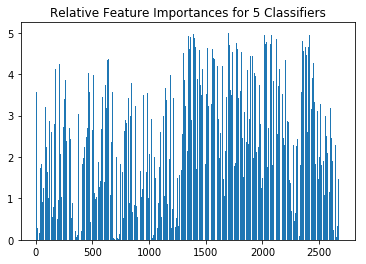

In [60]:
plt.bar(rankings.keys(), rankings.values())
plt.title("Relative Feature Importances for {} Classifiers".format(len(cache)))

Text(0.5,0,'Number of Features')

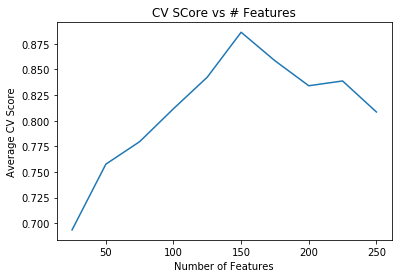

In [99]:
plt.plot(range(250,10,-25), avg_scores)
plt.ylabel("Average CV Score")
plt.title("CV SCore vs # Features")
plt.xlabel("Number of Features")

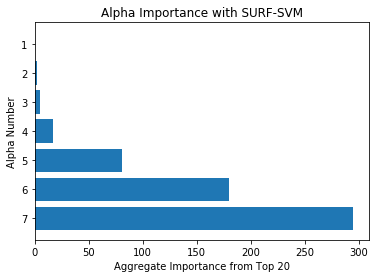

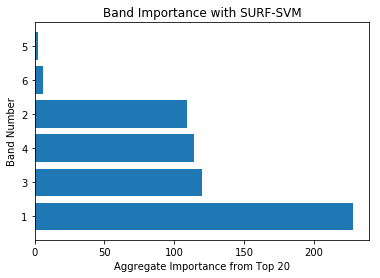

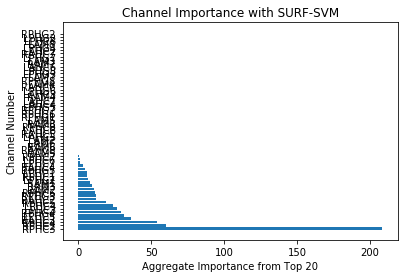

In [69]:

def get_best_surf_features(surfs, num_features = 20):
    
    alpha_usage = collections.defaultdict(int)
    channel_usage = collections.defaultdict(int)
    band_usage = collections.defaultdict(int)

    for surf in surfs:
        top_idx = np.argsort(surf.feature_importances_)[-num_features:]
        for f in top_idx:
            # get the best channel by occrence
            channel = chan_names[feature_names[f][2]]
            channel_usage[channel]              += surf.feature_importances_[f]
            alpha_usage[feature_names[f][0]]    += surf.feature_importances_[f]
            band_usage[feature_names[f][1]]     += surf.feature_importances_[f]

    return alpha_usage, band_usage, channel_usage
    
alpha_usage, band_usage,channel_usage = get_best_surf_features(c_ictal_multisirf)
        
f = make_barplot(alpha_usage, "Alpha")
f = make_barplot(band_usage, "Band")
f = make_barplot(channel_usage, "Channel")



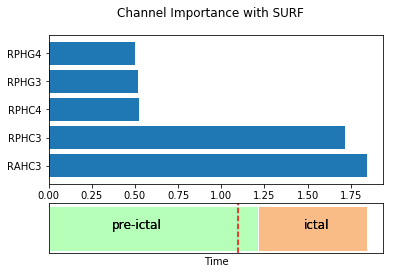

In [125]:
surf_list = c_multisurf
fig, (ax1, ax2) = plt.subplots(nrows=2, gridspec_kw = {'height_ratios':[3, 1]})
frames = [[get_best_surf_features([_c], num_features=20)[2], i] for i,_c in enumerate(surf_list)]
label = 'Channel'
num_chans = 5 

# get distribution of class type from the data 
num_samps = 15220
preictal_len = 10000/num_samps
ictal_len = 5220/num_samps

title = 'Surf star'

marking_line = ax2.axvline(0.75, ls='--', color='r')
marking_idx = 0 

def init():    
    #ax1.ylabel(label + " Number")
    #ax1.xlabel("Aggregate Importance from Top 20")
    ax2.barh(0, preictal_len, color='#b5ffb9', edgecolor='white', height=0.5)
    ax2.barh(0, ictal_len, left=preictal_len, color='#f9bc86', edgecolor='white', height=0.5)  
    ax2.text(0.2, 0, 'pre-ictal', fontsize=12)
    ax2.text(0.8, 0, 'ictal', fontsize=12)

    ax2.set_xlabel('Time')
    ax2.set_yticks([])
    ax2.set_xticks([])
    return [ax1,ax2]
    
def update(frame, num_frames, num_chans):
    data = frame[0]
    idx = frame[1]
    t = list(data.items())
    t.sort(key=lambda tup: tup[1], reverse=True)
    t = t[:num_chans]
    cnames,val = zip(*t)
    y_pos = np.arange(num_chans)
    fig.suptitle('Channel Importance with SURF')

    ax1.cla()
    ax1.barh(np.arange(len(val)), val, tick_label=cnames)
    #for r,v in zip(rect,val):
    #    r.set_width(v)
    # ax1.set_yticklabels(y_pos, cnames)
    
    marking_line.set_xdata([idx/len(frames)])
    # ax2.axvline(idx/num_frames, ls='--', color='r')
    return [ax1,ax2]

    
# Then what is left is to animate the whole thing.

init()
update(frames[80], len(frames), num_chans)

ani = FuncAnimation(fig, update, frames=frames, init_func = init,
                    blit=False, interval =250 ,repeat=True, fargs=(len(frames), num_chans))


plt.show()

#ani.save(title+'.mp4')

In [68]:
[x for x in vars() if 'c' in x]

['__doc__',
 '__package__',
 '__spec__',
 'scipy',
 'cross_validate',
 'GridSearchCV',
 'classification_report',
 'cross_val_score',
 'FuncAnimation',
 'pickle',
 'collections',
 'archive_data',
 'archive_data_ena',
 'chan_names',
 'windowed_comparison',
 'c',
 'channel_usage',
 'num_chans',
 'preictal_len',
 'ictal_len',
 'c_interictal',
 'datafiles_ictal',
 'c_ictal',
 'c_ictal_multisirf']

In [103]:
archive_data(c_ictal_surfstar, 'c_ictal_surfstar.pickle')

In [ ]:

class UpdateImportance(object):
    def __init__(self, ax, prob=0.5):
        self.success = 0
        self.prob = prob
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 15)
        self.ax.grid(True)

        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        self.ax.axvline(prob, linestyle='--', color='black')

    def init(self):
        self.success = 0
        self.line.set_data([], [])
        return self.line,

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            return self.init()

        # Choose success based on exceed a threshold with a uniform pick
        if np.random.rand(1,) < self.prob:
            self.success += 1
        y = ss.beta.pdf(self.x, self.success + 1, (i - self.success) + 1)
        self.line.set_data(self.x, y)
        return self.line,
